In [1]:
# Custom Params
IMAGE_SIZE = (128, 128)
TEST_DATA_SIZE = 0.2

# Data Loading

In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Path to the dataset
data_dir = '/kaggle/input/plantdisease/PlantVillage'

# Classes (labels) based on folder names in the dataset
classes = [plant for plant in os.listdir("/kaggle/input/plantdisease/PlantVillage") if plant.startswith("Tomato")]
print(classes)

# Mapper dictionary
class_mapper = {
    'Tomato_Leaf_Mold': 'Leaf Mold',
    'Tomato__Tomato_YellowLeaf__Curl_Virus': 'Yellow Leaf Curl Virus',
    'Tomato_Bacterial_spot': 'Bacterial Spot',
    'Tomato_Septoria_leaf_spot': 'Septoria Leaf Spot',
    'Tomato_healthy': 'Healthy',
    'Tomato_Spider_mites_Two_spotted_spider_mite': 'Spider Mites',
    'Tomato_Early_blight': 'Early Blight',
    'Tomato__Target_Spot': 'Target Spot',
    'Tomato_Late_blight': 'Late Blight',
    'Tomato__Tomato_mosaic_virus': 'Mosaic Virus'
}

['Tomato_Leaf_Mold', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Early_blight', 'Tomato__Target_Spot', 'Tomato_Late_blight', 'Tomato__Tomato_mosaic_virus']


In [3]:
X = []
y = []

for label, class_name in tqdm(enumerate(classes)):
    class_dir = os.path.join(data_dir, class_name)
    label_name = class_mapper[class_name]
    
    if not os.path.isdir(class_dir):
        continue
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        
        # Read the image using OpenCV
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, IMAGE_SIZE)           # Resize image: Preprocessing
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Converting BGR to RGB: Preprocessing
            X.append(img)
            y.append(label_name)

# Converting lists to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"Data loaded successfully: {X.shape[0]} images with size {X.shape[1:]}")

10it [01:16,  7.67s/it]


Data loaded successfully: 16011 images with size (128, 128, 3)


# Data Exploration

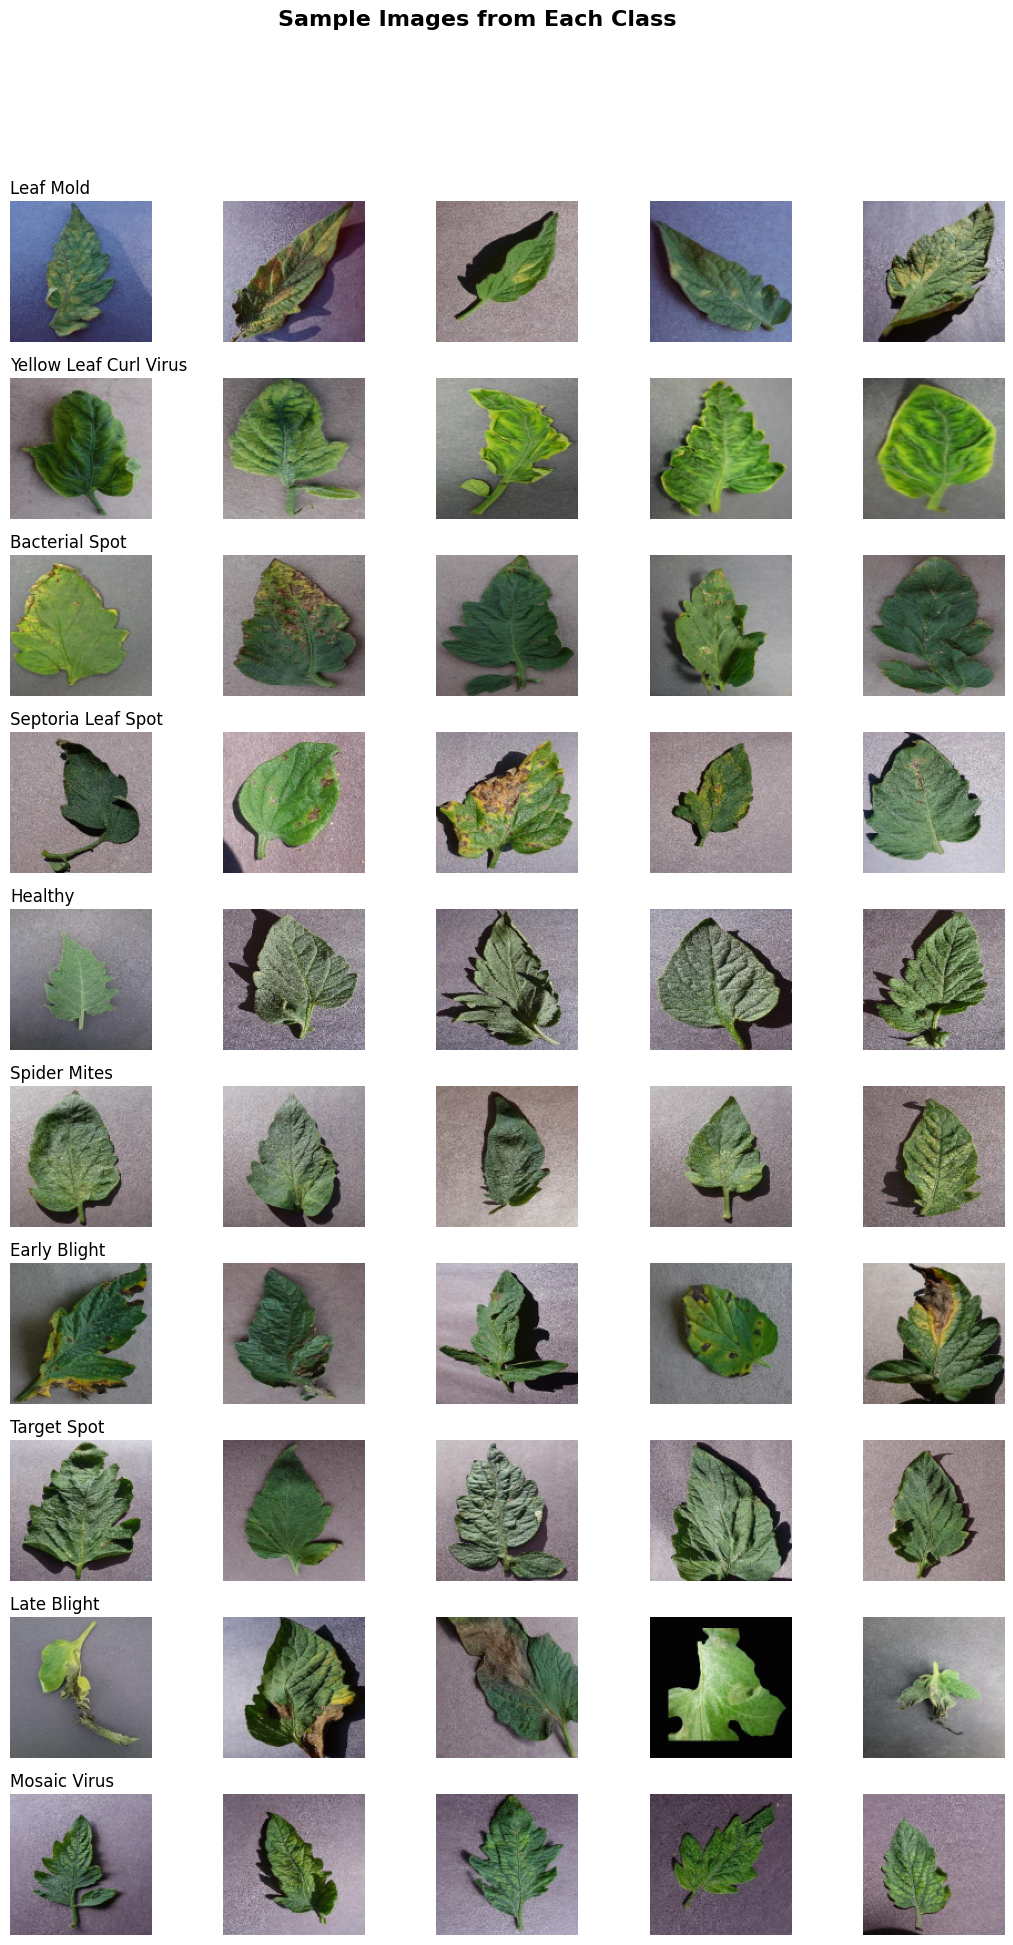

In [4]:
import matplotlib.pyplot as plt
from collections import defaultdict

samples_per_class = 5
fig, axes = plt.subplots(len(class_mapper), samples_per_class, figsize=(12, len(class_mapper) * 2))
fig.suptitle("Sample Images from Each Class", fontsize=16, weight='bold', y=1.02)

# Indices by class for easy access
class_indices = defaultdict(list)
for idx, label in enumerate(y):
    class_indices[label].append(idx)

# Display images
for class_idx, (class_name, indices) in enumerate(class_indices.items()):
    selected_indices = np.random.choice(indices, samples_per_class, replace=False)

    for i, idx in enumerate(selected_indices):
        ax = axes[class_idx, i]
        ax.imshow(X[idx])
        ax.axis("off")

    # Label as a title for each row
    axes[class_idx, 0].set_title(class_name, fontsize=12, loc='left', pad=5)

# Adjusting layout for better spacing
plt.subplots_adjust(wspace=0.1, hspace=0.4)
plt.tight_layout(rect=[0.05, 0.05, 1, 0.96])
plt.show()